In [3]:
# Step 1: Install Required Libraries
!pip install shap xgboost --quiet

In [4]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [6]:
# Step 3: Load Data

df = pd.read_csv('adult 3.csv')

In [9]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,39,0


In [10]:
df.tail()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,4,257302,7,12,2,13,5,4,0,0,0,38,39,0
48838,40,4,154374,11,9,2,7,0,4,1,0,0,40,39,1
48839,58,4,151910,11,9,6,1,4,4,0,0,0,40,39,0
48840,22,4,201490,11,9,4,1,3,4,1,0,0,20,39,0
48841,52,5,287927,11,9,2,4,5,4,0,15024,0,40,39,1


In [13]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [11]:
# Step 4: Preprocessing
df.dropna(inplace=True)
label_encoders = {}

for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [14]:
# Step 5: Split Data
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Step 6: Pipelines for Models
scaler = StandardScaler()

pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', scaler),
        ('lr', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('scaler', scaler),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('scaler', scaler),
        ('xgb', XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss'))
    ])
}


In [16]:
# Step 7: Evaluate Models
results = []

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({
        'Model': name,
        'Accuracy': acc
    })
    print(f"\n--- {name} ---")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



--- Logistic Regression ---
Accuracy: 0.8272085167366158
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      7479
           1       0.71      0.45      0.55      2290

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.82      0.83      0.81      9769

Confusion Matrix:
 [[7054  425]
 [1263 1027]]

--- Random Forest ---
Accuracy: 0.8695874705701709
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      7479
           1       0.77      0.63      0.69      2290

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.81      9769
weighted avg       0.86      0.87      0.86      9769

Confusion Matrix:
 [[7051  428]
 [ 846 1444]]

--- XGBoost ---
Accuracy: 0.8803357559627393
Classification Report:
               precision   

In [17]:
# Step 8: Results Table
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\n🔍 Model Comparison Table:")
print(results_df)



🔍 Model Comparison Table:
                 Model  Accuracy
2              XGBoost  0.880336
1        Random Forest  0.869587
0  Logistic Regression  0.827209


In [18]:
# Step 9: Select Best Model (XGBoost) for Interpretation
best_pipeline = pipelines['XGBoost']
best_model = best_pipeline.named_steps['xgb']
best_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

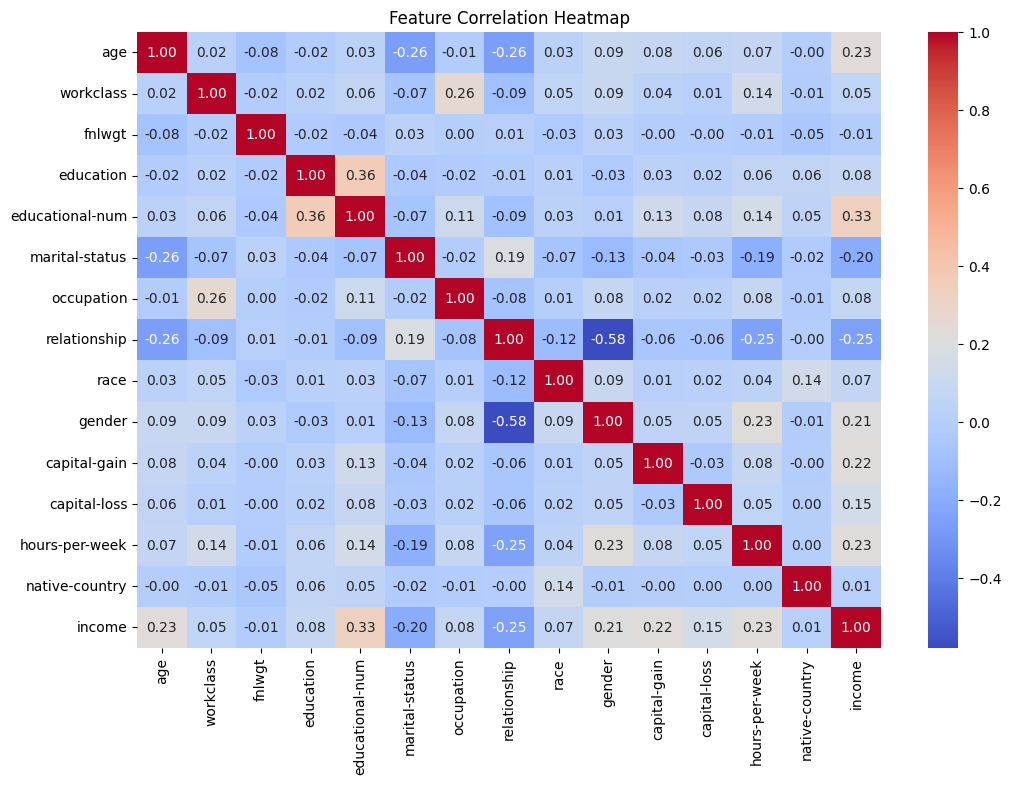

In [19]:
# Step 10: Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


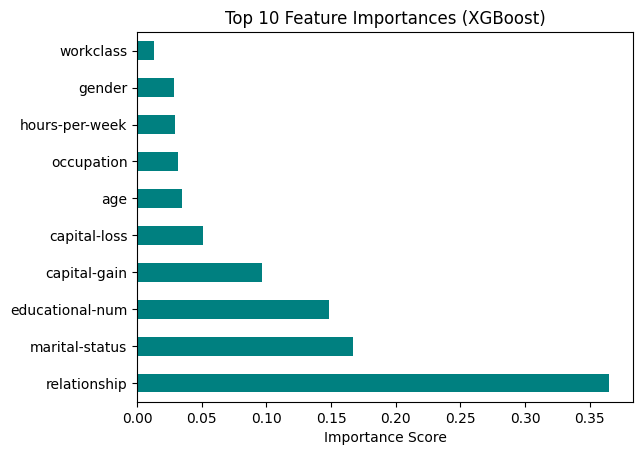

In [20]:
# Step 11: Feature Importance (XGBoost)
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.show()

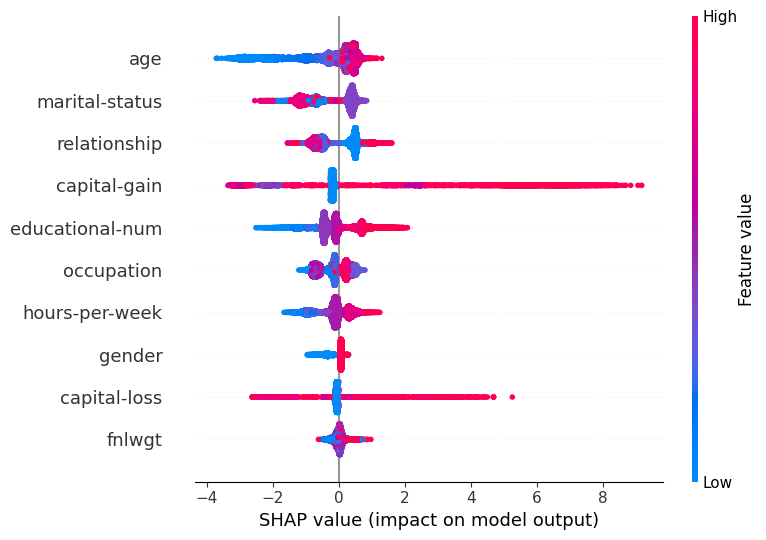

In [21]:
# Step 12: SHAP Summary Plot
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, max_display=10)


In [22]:
import joblib

# Save model
joblib.dump(best_model, 'best_salary_model.pkl')

['best_salary_model.pkl']